# Create SpatialData objects from scratch

There might be situations in which one would like to benefit from the SpatialData ecosystem without necessarily coming from a place where the readers from [spatialdata-io](https://spatialdata.scverse.org/projects/io/en/latest/) can be used to create the SpatialData objects. This notebook will show how to create SpatialData objects from scratch.

For this, we will use a simple example dataset that does not come from the spatial-omics world, to focus entirely on the creation of the SpatialData object.

http://hms-dbmi.github.io/vizarr/?source=https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.3/idr0095B/11511419.zarr

In [1]:
url_img = "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.3/idr0095B/11511419.zarr"
url_labels = "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.3/idr0095B/11511419.zarr/labels/0"

In [2]:
# Use ngff_zarr to read the data, as in the OME-Zarr + dask tutorial

import spatialdata # make sure to import spatialdata before ngff_zarr, otherwise dask-expr related error
import ngff_zarr as nz

multiscales_img = nz.from_ngff_zarr(url_img)
multiscales_labels = nz.from_ngff_zarr(url_labels)

/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [3]:
# get the channel names from the OME-Zarr metadata
import zarr

g = zarr.group(url_img)
channel_names = [c["label"] for c in g.attrs["omero"]["channels"]]
print("Channel names: ", channel_names)

Channel names:  ['Phase', 'YFP', 'Tx Red']


Let's create an instance segmentation from the labels

In [4]:
from dask_image import ndmeasure

img = multiscales_img.images[0].data
seg = multiscales_labels.images[0].data[0] > 0

# seg is a semantic segmentation
# therefore label connected components using dask-image
labels = ndmeasure.label(seg)[0]

Let's plot the image together with the segmentation.

Text(0.5, 1.0, 'Segmentation')

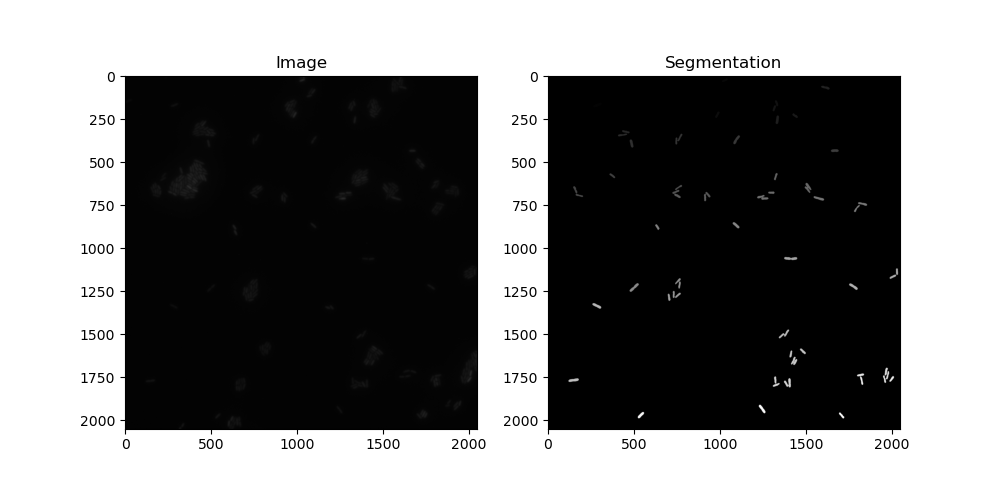

In [5]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img[1], cmap="gray")
axs[0].set_title("Image")
axs[1].imshow(labels, cmap="gray")
axs[1].set_title("Segmentation")

## Create an image and labels element

In [6]:
from spatialdata.models import Image2DModel, Labels2DModel

image_element = Image2DModel.parse(
    img,
    dims=["c", "y", "x"],
    c_coords=channel_names,
    scale=multiscales_img.images[0].scale, # set pixel spacing
)

labels_element = Labels2DModel.parse(
    labels,
    dims=["y", "x"],
    scale=multiscales_labels.images[0].scale, # set pixel spacing
)

## Create a shapes element

`spatialdata` provides a convenience function to convert labels into shapes: `to_polygons`.

In [7]:
from spatialdata import to_polygons

shapes_element = to_polygons(labels_element)

# to_polygons seems to save labels as float
# convert index to uint16
shapes_element.index = shapes_element.index.astype(int)
shapes_element["label"] = shapes_element["label"].astype(int)
shapes_element

,label,geometry
label,,
1,1,"POLYGON ((273 182.5, 272 182.5, 271 182.5, 270..."
2,2,"POLYGON ((1025 32.5, 1026 32.5, 1026.5 32, 102..."
3,3,"POLYGON ((977 244.5, 976 244.5, 975 244.5, 974..."
4,4,"POLYGON ((1332 176.5, 1331 176.5, 1330.5 176, ..."
5,5,"POLYGON ((1311 205.5, 1310 205.5, 1309 205.5, ..."
6,6,"POLYGON ((1446 244.5, 1445 244.5, 1444 244.5, ..."
7,7,"POLYGON ((1339 256.5, 1339.5 256, 1339.5 255, ..."
8,8,"POLYGON ((1629 79.5, 1628 79.5, 1627 79.5, 162..."
9,9,"POLYGON ((469 333.5, 468 333.5, 467 333.5, 466..."


## Create the spatialdata object

In [8]:
import spatialdata as sd

sdata = sd.SpatialData(
    images={'my_image': image_element},
    labels={'my_labels': labels_element},
    shapes={'my_shapes': shapes_element},
)

## Visualize the spatialdata object

Notice that for the image layer several channels are available on the right menu now.

In [9]:
from napari_spatialdata import Interactive

Interactive(sdata)

## Add annotations table

Let's add an annotation table containing feature information about the objects in the image.

We can use scikit-image to extract features from the image and labels.


In [10]:
# extract features using regionprops

from skimage import measure
import numpy as np

props = measure.regionprops_table(
    np.array(labels),
    properties=[
        "label",
        "area",
        "eccentricity",
        "orientation",
        "perimeter",
        "solidity",
    ],
)

props


{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59]),
 'area': array([ 713.,  405.,  482.,  413.,  407.,  435.,  709.,  611.,  478.,
         505.,  677.,  881.,  813.,  631.,  419.,  491.,  407.,  410.,
         460.,  439.,  493.,  446.,  455., 1095.,  416.,  980.,  787.,
         612.,  445.,  415.,  659.,  941.,  421.,  402.,  406.,  418.,
         461., 1047.,  411.,  456.,  794.,  781.,  897.,  866.,  508.,
         432.,  923.,  441., 1113.,  441.,  510.,  444.,  472.,  401.,
         406.,  476.,  646.,  800.,  451.]),
 'eccentricity': array([0.95321787, 0.93870798, 0.94707111, 0.93058124, 0.94083288,
        0.92782252, 0.94851321, 0.96356365, 0.96418534, 0.98142667,
        0.94422783, 0.95146251, 0.96645585, 0.93418119, 0.95179256,
        0.96184306, 0.

Next we create an anndata object with the obtained features.

In [11]:
import pandas as pd
import anndata as ad

adata = ad.AnnData(np.array([v for v in props.values()]).T)
adata.var_names = list(props.keys())

Turn the anndata object into a table element.

In [12]:
from spatialdata.models import TableModel

adata_for_sdata = TableModel.parse(adata)
adata_for_sdata

AnnData object with n_obs × n_vars = 59 × 6

### Connect the `AnnData` to the `Shapes` object

In [13]:
adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "my_shapes",  # name of the Shapes element
    "region_key": "region",  # column in adata.obs that will link a given obs to the elements it annotates
    "instance_key": "shape_id",  # column that matches a given obs in the table to a given circle
}
# all the rows of adata annotate the same element, called "spots" (as we declared above)
adata.obs["region"] = pd.Categorical(["my_shapes"] * len(adata))
adata.obs["shape_id"] = sdata["my_shapes"].index


In [14]:
# instead, we could also connect the table to the labels element

# adata_for_sdata.uns["spatialdata_attrs"] = {
#     "region": "my_labels",  # name of the Shapes element
#     "region_key": "region",  # column in adata.obs that will link a given obs to the elements it annotates
#     "instance_key": "instance_id",  # column that matches a given obs in the table to a given circle
# }
# # all the rows of adata annotate the same element, called "spots" (as we declared above)
# adata.obs["region"] = pd.Categorical(["my_labels"] * len(adata))

# from spatialdata import get_element_instances
# adata.obs["instance_id"] = get_element_instances(sdata["my_labels"])

Add the tables element to the spatialdata object.

In [15]:
sdata["my_table"] = adata_for_sdata

### Visualize the finalized spatialdata object.

Notice how the the table is now available in the right menu. You can select the table and the shapes to visualize the features of the objects in the image.


In [16]:
Interactive(sdata)

### Plot the features using spatialdata

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04877833..1.0].


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `my_shapes` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `my_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04877833..1.0].
/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `my_shapes` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/spatialdata/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `my_table` already exists. Overwri

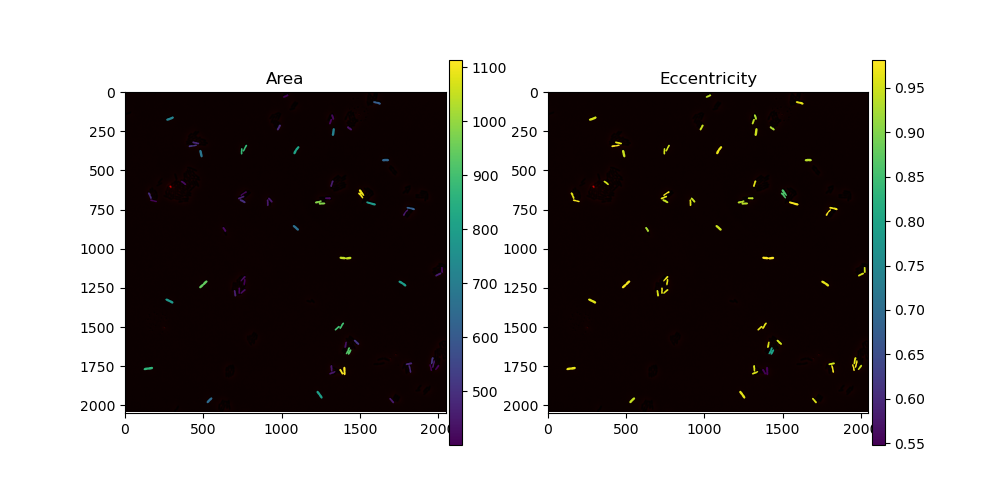

In [ ]:
import spatialdata_plot

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sdata.pl.render_images().pl.render_shapes(color="area").pl.show(ax=axs[0], title="Area")
sdata.pl.render_images().pl.render_shapes(color="eccentricity").pl.show(ax=axs[1], title="Eccentricity")